In [44]:
import os

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from scipy.ndimage import rotate
from scipy.stats import pearsonr

from tqdm import tqdm

%matplotlib inline

In [3]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, Add, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.reduce_sum(tf.random.normal([1000, 1000])))
print(tf.config.list_physical_devices('GPU'))

Num GPUs Available:  1
tf.Tensor(1242.0112, shape=(), dtype=float32)
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-01-26 09:26:38.767785: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-26 09:26:39.190501: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38420 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:41:00.0, compute capability: 8.0


## VNet Implementation
> https://arxiv.org/pdf/1606.04797.pdf

In [5]:
def conv_block(input_tensor, num_filters):
    shortcut = Conv3D(num_filters, (1,1,1), padding='same')(input_tensor) # skip connection added for residual connection
    x = Conv3D(num_filters, (3,3,3), padding='same')(input_tensor)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    x = Conv3D(num_filters, (3,3,3), padding='same')(x)
    x = Activation('relu')(x)
    return Add()([x, shortcut]) # residual connection as per the VNET paper64

In [6]:
def encoder_block(input_tensor, num_filters):
    x = conv_block(input_tensor, num_filters)
    p = MaxPooling3D((2,2,2))(x)
    p = Dropout(0.5)(p)
    return x, p

In [7]:
def decoder_block(input_tensor, concat_tensor, num_filters):
    x = UpSampling3D((2,2,2))(input_tensor)
    x = Conv3D(num_filters, (1,1,1))(x) # 1X1X1 convolution operation to match the filters
    x = Add()([x, concat_tensor]) # skip connection implementation. VNET is a variant of UNET.
    x = conv_block(x, num_filters)
    return x

In [8]:
def vnet_regression(input_shape):
    inputs = Input(input_shape)
    
    e0, p0 = encoder_block(inputs, 16)
    e1, p1 = encoder_block(p0, 32)
    e2, p2 = encoder_block(p1, 64)
    e3, p3 = encoder_block(p2, 128)
    
    b0 = conv_block(p3, 256)
    
    d3 = decoder_block(b0, e3, 128)
    d2 = decoder_block(d3, e2, 64)
    d1 = decoder_block(d2, e1, 32)
    d0 = decoder_block(d1, e0, 16)
    
    outputs = Conv3D(1, (1,1,1), activation='linear')(d0)
    
    model = Model(inputs=[inputs], outputs=[outputs], name="vnet_regression")
    
    return model

------

In [12]:
data = np.load('./generated_data/simulated_data_010124_5K.npy')

--------

In [13]:
os.environ['PYTHONHASHSEED']=str(123)

np.random.seed(123)
tf.random.set_seed(123)

In [14]:
# Split the data
initial_state = data[:, 0]
final_state = data[:, 1]

# Compute the mean and std of the initial and final states
initial_state_mean, initial_state_std = np.mean(initial_state), np.std(initial_state)
final_state_mean, final_state_std = np.mean(final_state), np.std(final_state)

# Normalize the initial and final states
initial_state = (initial_state - initial_state_mean) / initial_state_std
final_state = (final_state - final_state_mean) / final_state_std

# Select one simulation's initial and final states
initial_conditions = initial_state[0]
final_density = final_state[0]

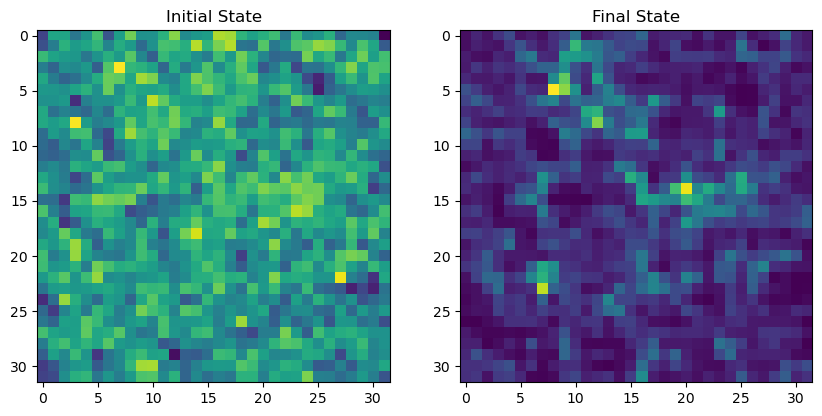

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
# initial state and final state
axes[0].imshow(initial_conditions[0], cmap='viridis')
axes[0].set_title("Initial State")

axes[1].imshow(final_density[0], cmap='viridis')  
axes[1].set_title("Final State")

plt.show()

In [16]:
# train and test
X_train, X_test, y_train, y_test  = train_test_split(initial_state, final_state, test_size=0.15, random_state=123)

# further splitting it in training and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=123)

## Adding a data augmentation step

In [17]:
def augment_data_3d(data):
    # Rotate the data along different axes
    angle_x, angle_y, angle_z = np.random.uniform(0, 360), np.random.uniform(0, 360), np.random.uniform(0, 360)

    # Apply rotation
    rotated_data = rotate(data, angle_x, axes=(0, 1), reshape=False)
    rotated_data = rotate(rotated_data, angle_y, axes=(1, 2), reshape=False)
    rotated_data = rotate(rotated_data, angle_z, axes=(0, 2), reshape=False)

    return rotated_data

X_train_augmented = np.array([augment_data_3d(x) for x in tqdm(X_train, desc="Augmenting Data")])

Augmenting Data: 100%|███████████████████████████████████████████████████████████| 3612/3612 [00:45<00:00, 79.44it/s]


In [18]:
X_train.shape, X_train_augmented.shape

((3612, 32, 32, 32), (3612, 32, 32, 32))

In [19]:
# Combine original and augmented data
X_train_combined = np.concatenate((X_train, X_train_augmented), axis=0)
y_train_combined = np.concatenate((y_train, y_train), axis=0)  # Duplicate Y labels for augmented data

In [20]:
# Remove and store a specific sample from X_val and y_val for the special test
index_to_remove = np.random.randint(len(X_val))  # Random index
X_val_special_test = X_val[index_to_remove]
y_val_special_test = y_val[index_to_remove]  # Corresponding target

# Remove the sample from X_val and y_val
X_val = np.delete(X_val, index_to_remove, axis=0)
y_val = np.delete(y_val, index_to_remove, axis=0)

In [21]:
# reshaping the datasets
# Recasting dimensions to 4D tensor (suitable for 3D convolutions) with the 
# following dimensions: (batch_size, height, width, depth, num_channels)
X_train_combined = np.reshape(X_train_combined, (*X_train_combined.shape, 1))
X_val = np.reshape(X_val, (*X_val.shape, 1))
X_test = np.reshape(X_test, (*X_test.shape, 1))

y_train_combined = np.reshape(y_train_combined, (*y_train_combined.shape, 1))
y_val = np.reshape(y_val, (*y_val.shape, 1))
y_test = np.reshape(y_test, (*y_test.shape, 1))

In [22]:
def remove_center_and_fill(data, fill_value=0):
    modified_data = np.copy(data)
    center = data.shape[0] // 2  # for a cubic grid
    small_cube_size = center // 2  # smaller cube

    # Calculate start and end indices for the smaller cube
    start = center - small_cube_size // 2
    end = center + small_cube_size // 2

    # Set the values in the smaller cube to fill_value
    modified_data[start:end, start:end, start:end] = fill_value

    return modified_data

In [23]:
# Process the special test sample
X_val_modified = remove_center_and_fill(X_val_special_test, fill_value=0)
if X_val_modified.ndim == 3:
    X_val_modified = np.expand_dims(X_val_modified, axis=-1)
X_val_modified = np.reshape(X_val_modified, (1, *X_val_modified.shape))

In [24]:
# Process the special test sample
X_val_modified = remove_center_and_fill(X_val_special_test, fill_value=0)
if X_val_modified.ndim == 3:
    X_val_modified = np.expand_dims(X_val_modified, axis=-1)
X_val_modified = np.reshape(X_val_modified, (1, *X_val_modified.shape))

In [25]:
X_val_modified.shape, y_val_special_test.shape

((1, 32, 32, 32, 1), (32, 32, 32))

In [26]:
X_train_combined.shape, y_train_combined.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((7224, 32, 32, 32, 1),
 (7224, 32, 32, 32, 1),
 (637, 32, 32, 32, 1),
 (637, 32, 32, 32, 1),
 (750, 32, 32, 32, 1),
 (750, 32, 32, 32, 1))

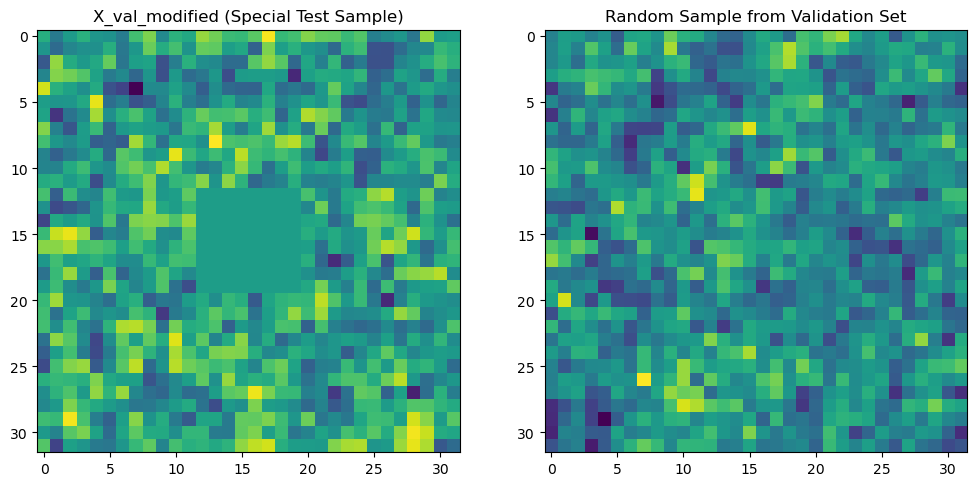

In [27]:
import matplotlib.pyplot as plt

# X_val_modified
plt.figure(figsize=(12, 6))

# slice of X_val_modified (it is a 3D voxel)
plt.subplot(1, 2, 1)
plt.imshow(X_val_modified[0, :, :, X_val_modified.shape[3] // 2, 0], cmap='viridis')
plt.title('X_val_modified (Special Test Sample)')

# slice from another random sample in the validation set
random_index = np.random.randint(len(X_val))
plt.subplot(1, 2, 2)
plt.imshow(X_val[random_index, :, :, X_val.shape[3] // 2, 0], cmap='viridis')
plt.title('Random Sample from Validation Set')

plt.show()

In [29]:
# savng special test sample and its corresponding target
np.save('vnet_experiment_3_saved_data/5K/X_val_special_test.npy', X_val_special_test)
np.save('vnet_experiment_3_saved_data/5K/y_val_special_test.npy', y_val_special_test)

# saving modified special test sample
np.save('vnet_experiment_3_saved_data/5K/X_val_modified.npy', X_val_modified)

# saving remaining validation and test sets
np.save('vnet_experiment_3_saved_data/5K/X_val.npy', X_val)
np.save('vnet_experiment_3_saved_data/5K/y_val.npy', y_val)
np.save('vnet_experiment_3_saved_data/5K/X_test.npy', X_test)
np.save('vnet_experiment_3_saved_data/5K/y_test.npy', y_test)

------
# VNET

In [30]:
# Parameters
Ngrid = 32  # grid size

In [31]:
vnet_model = vnet_regression((Ngrid, Ngrid, Ngrid, 1))

In [32]:
# Compile the model
vnet_model.compile(optimizer=Adam(), 
                   loss='mse',
                   metrics=['mae'],
                   run_eagerly=True)

In [33]:
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=5, 
                               restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=5, 
                              min_lr=0.001)
checkpoint = ModelCheckpoint('vnet_experiment_3_saved_data/5K/vnet_5K_260124.hdf5', 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True)

In [34]:
history = vnet_model.fit(x=X_train, 
                         y=y_train, 
                         validation_data=(X_val, y_val), 
                         batch_size=32, 
                         epochs=50, 
                         callbacks=[early_stopping, reduce_lr, checkpoint])

Epoch 1/50


2024-01-26 09:31:18.755957: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200
2024-01-26 09:31:29.482257: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


113/113 [==============================] - ETA: 0s - loss: 61.6621 - mae: 2.2889
Epoch 1: val_loss improved from inf to 0.93322, saving model to vnet_experiment_3_saved_data/vnet_5K_260124.hdf5
113/113 [==============================] - 29s 76ms/step - loss: 61.6621 - mae: 2.2889 - val_loss: 0.9332 - val_mae: 0.7304 - lr: 0.0010
Epoch 2/50
113/113 [==============================] - ETA: 0s - loss: 1.4229 - mae: 0.8925
Epoch 2: val_loss improved from 0.93322 to 0.90513, saving model to vnet_experiment_3_saved_data/vnet_5K_260124.hdf5
113/113 [==============================] - 8s 72ms/step - loss: 1.4229 - mae: 0.8925 - val_loss: 0.9051 - val_mae: 0.7052 - lr: 0.0010
Epoch 3/50
113/113 [==============================] - ETA: 0s - loss: 1.2514 - mae: 0.8264
Epoch 3: val_loss improved from 0.90513 to 0.88716, saving model to vnet_experiment_3_saved_data/vnet_5K_260124.hdf5
113/113 [==============================] - 8s 71ms/step - loss: 1.2514 - mae: 0.8264 - val_loss: 0.8872 - val_mae: 0.6

In [35]:
eval_results = vnet_model.evaluate(x=X_test, y=y_test)
print(f"Evaluation Results:{eval_results}")

24/24 [==============================] - 1s 28ms/step - loss: 0.5643 - mae: 0.5488
Evaluation Results:[0.5643118619918823, 0.5488396883010864]


In [36]:
predictions = vnet_model.predict(X_test)
predictions.shape

(750, 32, 32, 32, 1)

In [37]:
np.min(predictions), np.min(X_test), np.max(predictions), np.max(X_test)

(-1.9657668, -5.002735977640595, 5.3221884, 5.279904113089984)

In [38]:
vmin = min(np.min(predictions), np.min(X_test))
vmax = max(np.max(predictions), np.max(X_test))

vmin, vmax

(-5.002735977640595, 5.3221884)

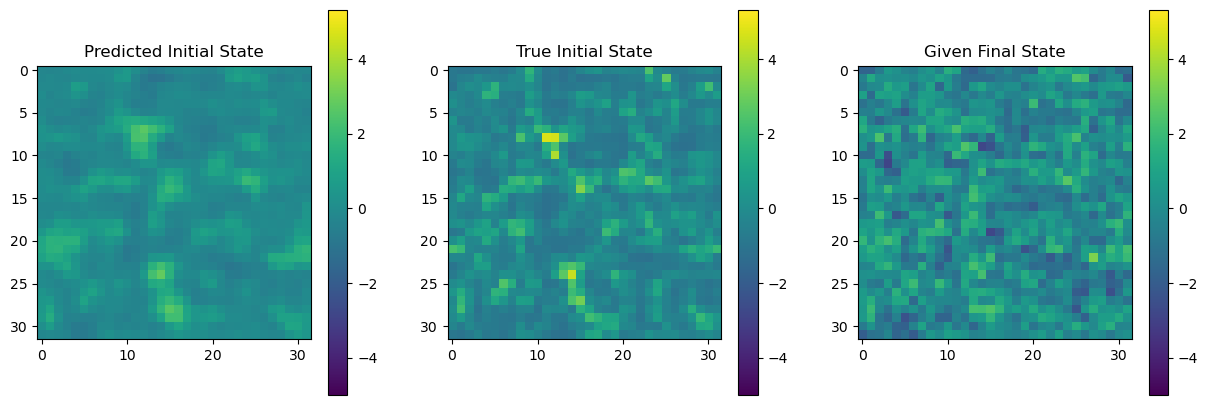

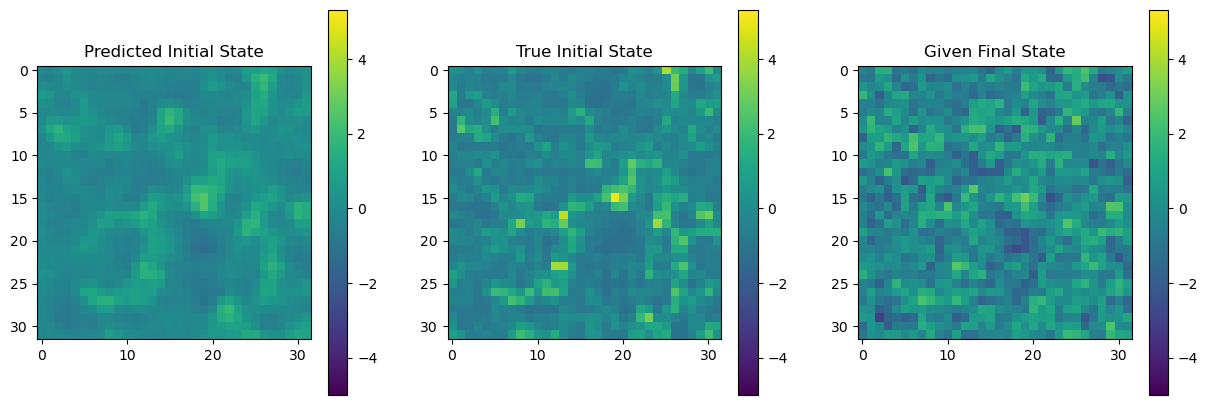

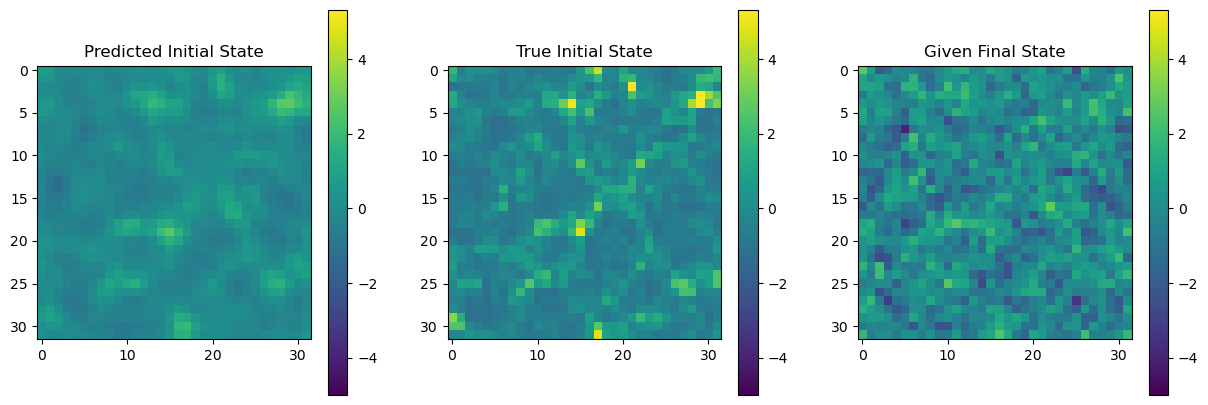

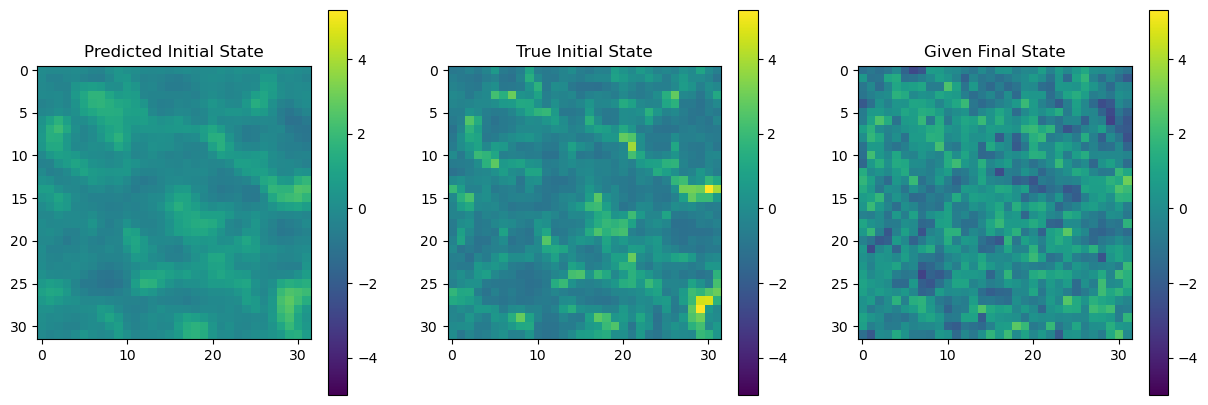

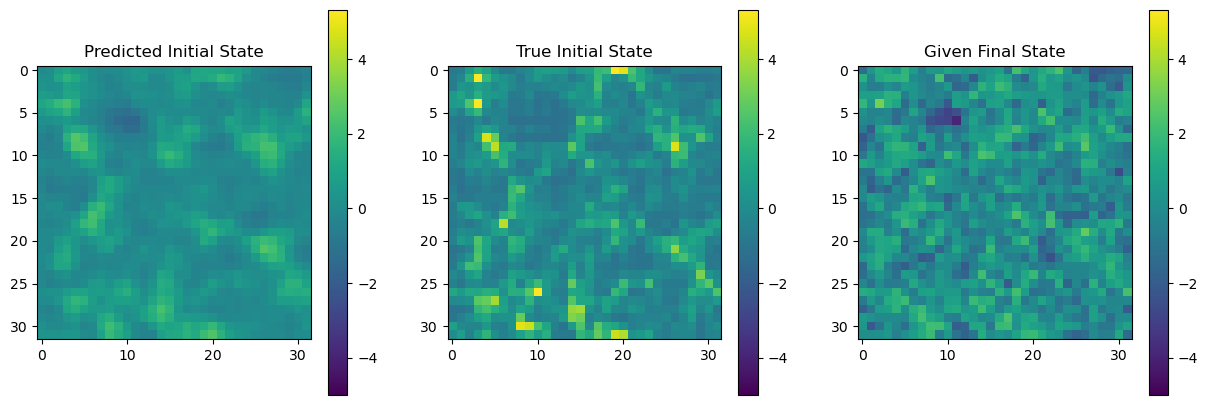

In [39]:
for test_index in range(5):  # Plot first 5 test cases
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # predicted initial state
    im = axs[0].imshow(predictions[test_index].reshape(Ngrid, Ngrid, Ngrid)[Ngrid//2], 
                       vmin=vmin, 
                       vmax=vmax,
                       cmap='viridis')
    axs[0].set_title('Predicted Initial State')
    fig.colorbar(im, ax=axs[0])

    # true initial state
    im = axs[1].imshow(y_test[test_index].reshape(Ngrid, Ngrid, Ngrid)[Ngrid//2], 
                       vmin=vmin, 
                       vmax=vmax,
                       cmap='viridis')
    axs[1].set_title('True Initial State')
    fig.colorbar(im, ax=axs[1])

    # True final state 
    im = axs[2].imshow(X_test[test_index].reshape(Ngrid, Ngrid, Ngrid)[Ngrid//2], 
                       vmin=vmin, 
                       vmax=vmax, 
                       cmap='viridis')
    axs[2].set_title('Given Final State')
    fig.colorbar(im, ax=axs[2])

    plt.show()

In [40]:
#error metrics
mse = mean_squared_error(y_test.flatten(), predictions.flatten())
mae = mean_absolute_error(y_test.flatten(), predictions.flatten())

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")

Mean Squared Error (MSE): 0.5643118057219123
Mean Absolute Error (MAE): 0.5488397638739932


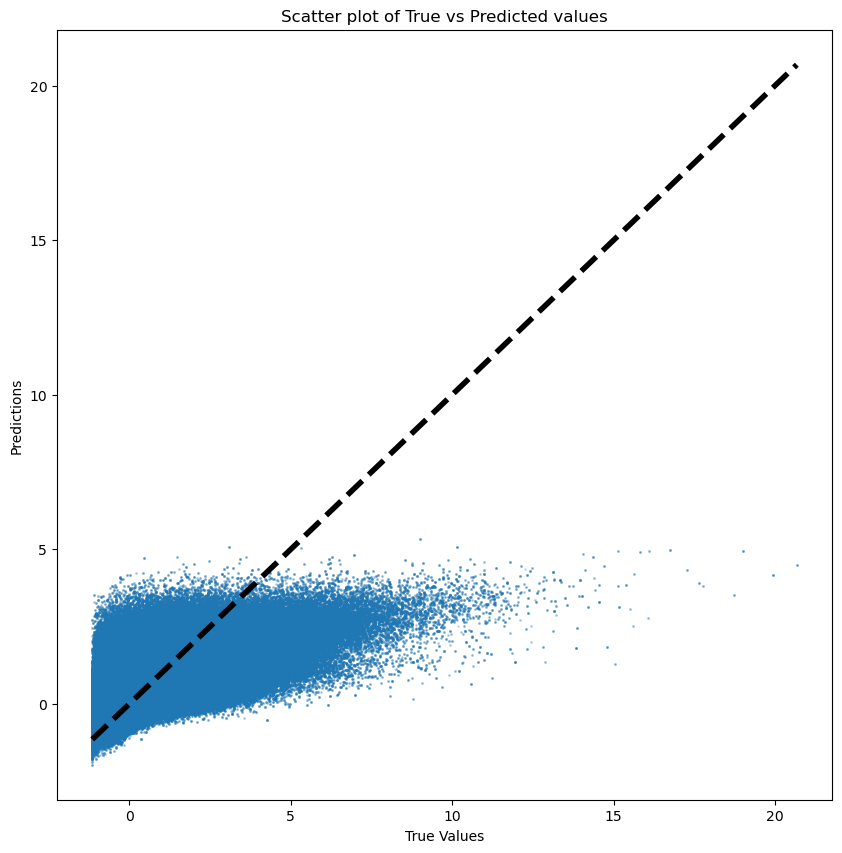

In [41]:
plt.figure(figsize=(10,10))
plt.scatter(y_test.flatten(), predictions.flatten(), alpha=0.1, s=1) # reduced marker size for easy plotting
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Scatter plot of True vs Predicted values')
plt.show()

------
### checking the prediction of the model on hidden ground truth sample.

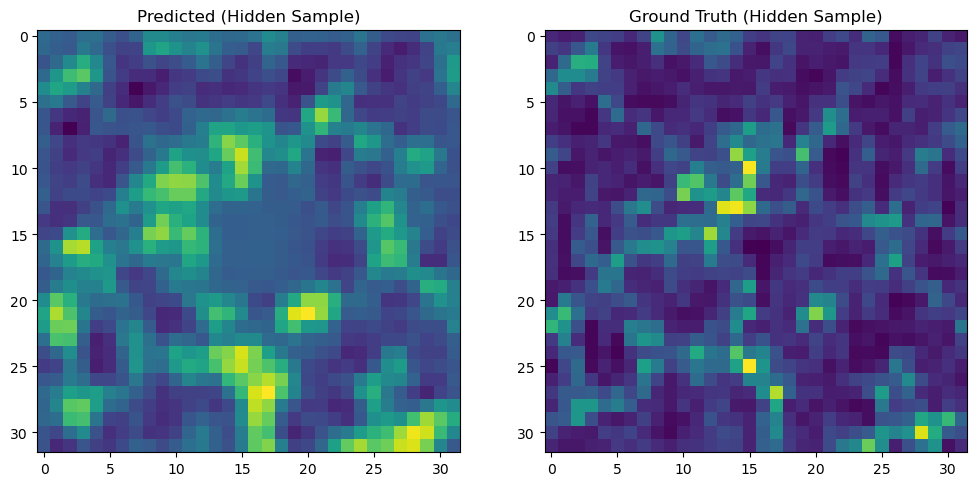

In [42]:
# Prediction hidden sample
hidden_sample_prediction = vnet_model.predict(X_val_modified)
plt.figure(figsize=(12, 6))

# Prediction
plt.subplot(1, 2, 1)
plt.imshow(hidden_sample_prediction[0, :, :, hidden_sample_prediction.shape[3] // 2, 0], cmap='viridis')
plt.title('Predicted (Hidden Sample)')

# Ground Truth
plt.subplot(1, 2, 2)
plt.imshow(y_val_special_test[:, :, y_val_special_test.shape[2] // 2], cmap='viridis')
plt.title('Ground Truth (Hidden Sample)')

plt.show()

In [45]:
mae = mean_absolute_error(y_val_special_test.flatten(), hidden_sample_prediction.flatten())
print("Mean Absolute Error (MAE):", mae)

mse = mean_squared_error(y_val_special_test.flatten(), hidden_sample_prediction.flatten())
print("Mean Squared Error (MSE):", mse)

# Calculate R-squared (Coefficient of Determination)
r2 = r2_score(y_val_special_test.flatten(), hidden_sample_prediction.flatten())
print("R-squared:", r2)

Mean Absolute Error (MAE): 0.5613447604362912
Mean Squared Error (MSE): 0.587128745958013
R-squared: 0.4018789273905926


In [46]:
# Flattening 3D arrays to 1D for correlation
flat_true = y_val_special_test.flatten()
flat_pred = hidden_sample_prediction.flatten()

pearson_corr_coefficient, _ = pearsonr(flat_true, flat_pred)
print("Pearson Correlation Coefficient:", pearson_corr_coefficient)

Pearson Correlation Coefficient: 0.6607013386850343


In [49]:
# Perform predictions on the training, validation, and test sets
train_predictions = vnet_model.predict(X_train_combined)
val_predictions = vnet_model.predict(X_val)
test_predictions = vnet_model.predict(X_test)

# Calculate metrics for each set
train_mae = mean_absolute_error(y_train_combined.flatten(), train_predictions.flatten())
train_mse = mean_squared_error(y_train_combined.flatten(), train_predictions.flatten())
train_r2 = r2_score(y_train_combined.flatten(), train_predictions.flatten())
train_pearson_corr, _ = pearsonr(y_train_combined.flatten(), train_predictions.flatten())

val_mae = mean_absolute_error(y_val.flatten(), val_predictions.flatten())
val_mse = mean_squared_error(y_val.flatten(), val_predictions.flatten())
val_r2 = r2_score(y_val.flatten(), val_predictions.flatten())
val_pearson_corr, _ = pearsonr(y_val.flatten(), val_predictions.flatten())

test_mae = mean_absolute_error(y_test.flatten(), test_predictions.flatten())
test_mse = mean_squared_error(y_test.flatten(), test_predictions.flatten())
test_r2 = r2_score(y_test.flatten(), test_predictions.flatten())
test_pearson_corr, _ = pearsonr(y_test.flatten(), test_predictions.flatten())

special_test_mae = mean_absolute_error(y_val_special_test.flatten(), hidden_sample_prediction.flatten())
special_test_mse = mean_squared_error(y_val_special_test.flatten(), hidden_sample_prediction.flatten())
special_test_r2 = r2_score(y_val_special_test.flatten(), hidden_sample_prediction.flatten())
special_test_pearson_corr, _ = pearsonr(y_val_special_test.flatten(), hidden_sample_prediction.flatten())

# Create a DataFrame to display the metrics
metrics_df = pd.DataFrame({
    'Metric': ['Mean Absolute Error', 'Mean Squared Error', 'R-squared', 'Pearson Correlation Coefficient'],
    'Training Set': [train_mae, train_mse, train_r2, train_pearson_corr],
    'Validation Set': [val_mae, val_mse, val_r2, val_pearson_corr],
    'Test Set': [test_mae, test_mse, test_r2, test_pearson_corr],
    'Ground Truth': [special_test_mae, special_test_mse, special_test_r2, special_test_pearson_corr]
})

metrics_df


,Metric,Training Set,Validation Set,Test Set,Special Test Case
0,Mean Absolute Error,0.692228,0.549110,0.548840,0.561345
1,Mean Squared Error,0.936711,0.565126,0.564312,0.587129
2,R-squared,0.063385,0.434621,0.435641,0.401879
3,Pearson Correlation Coefficient,0.373248,0.683040,0.683859,0.660701


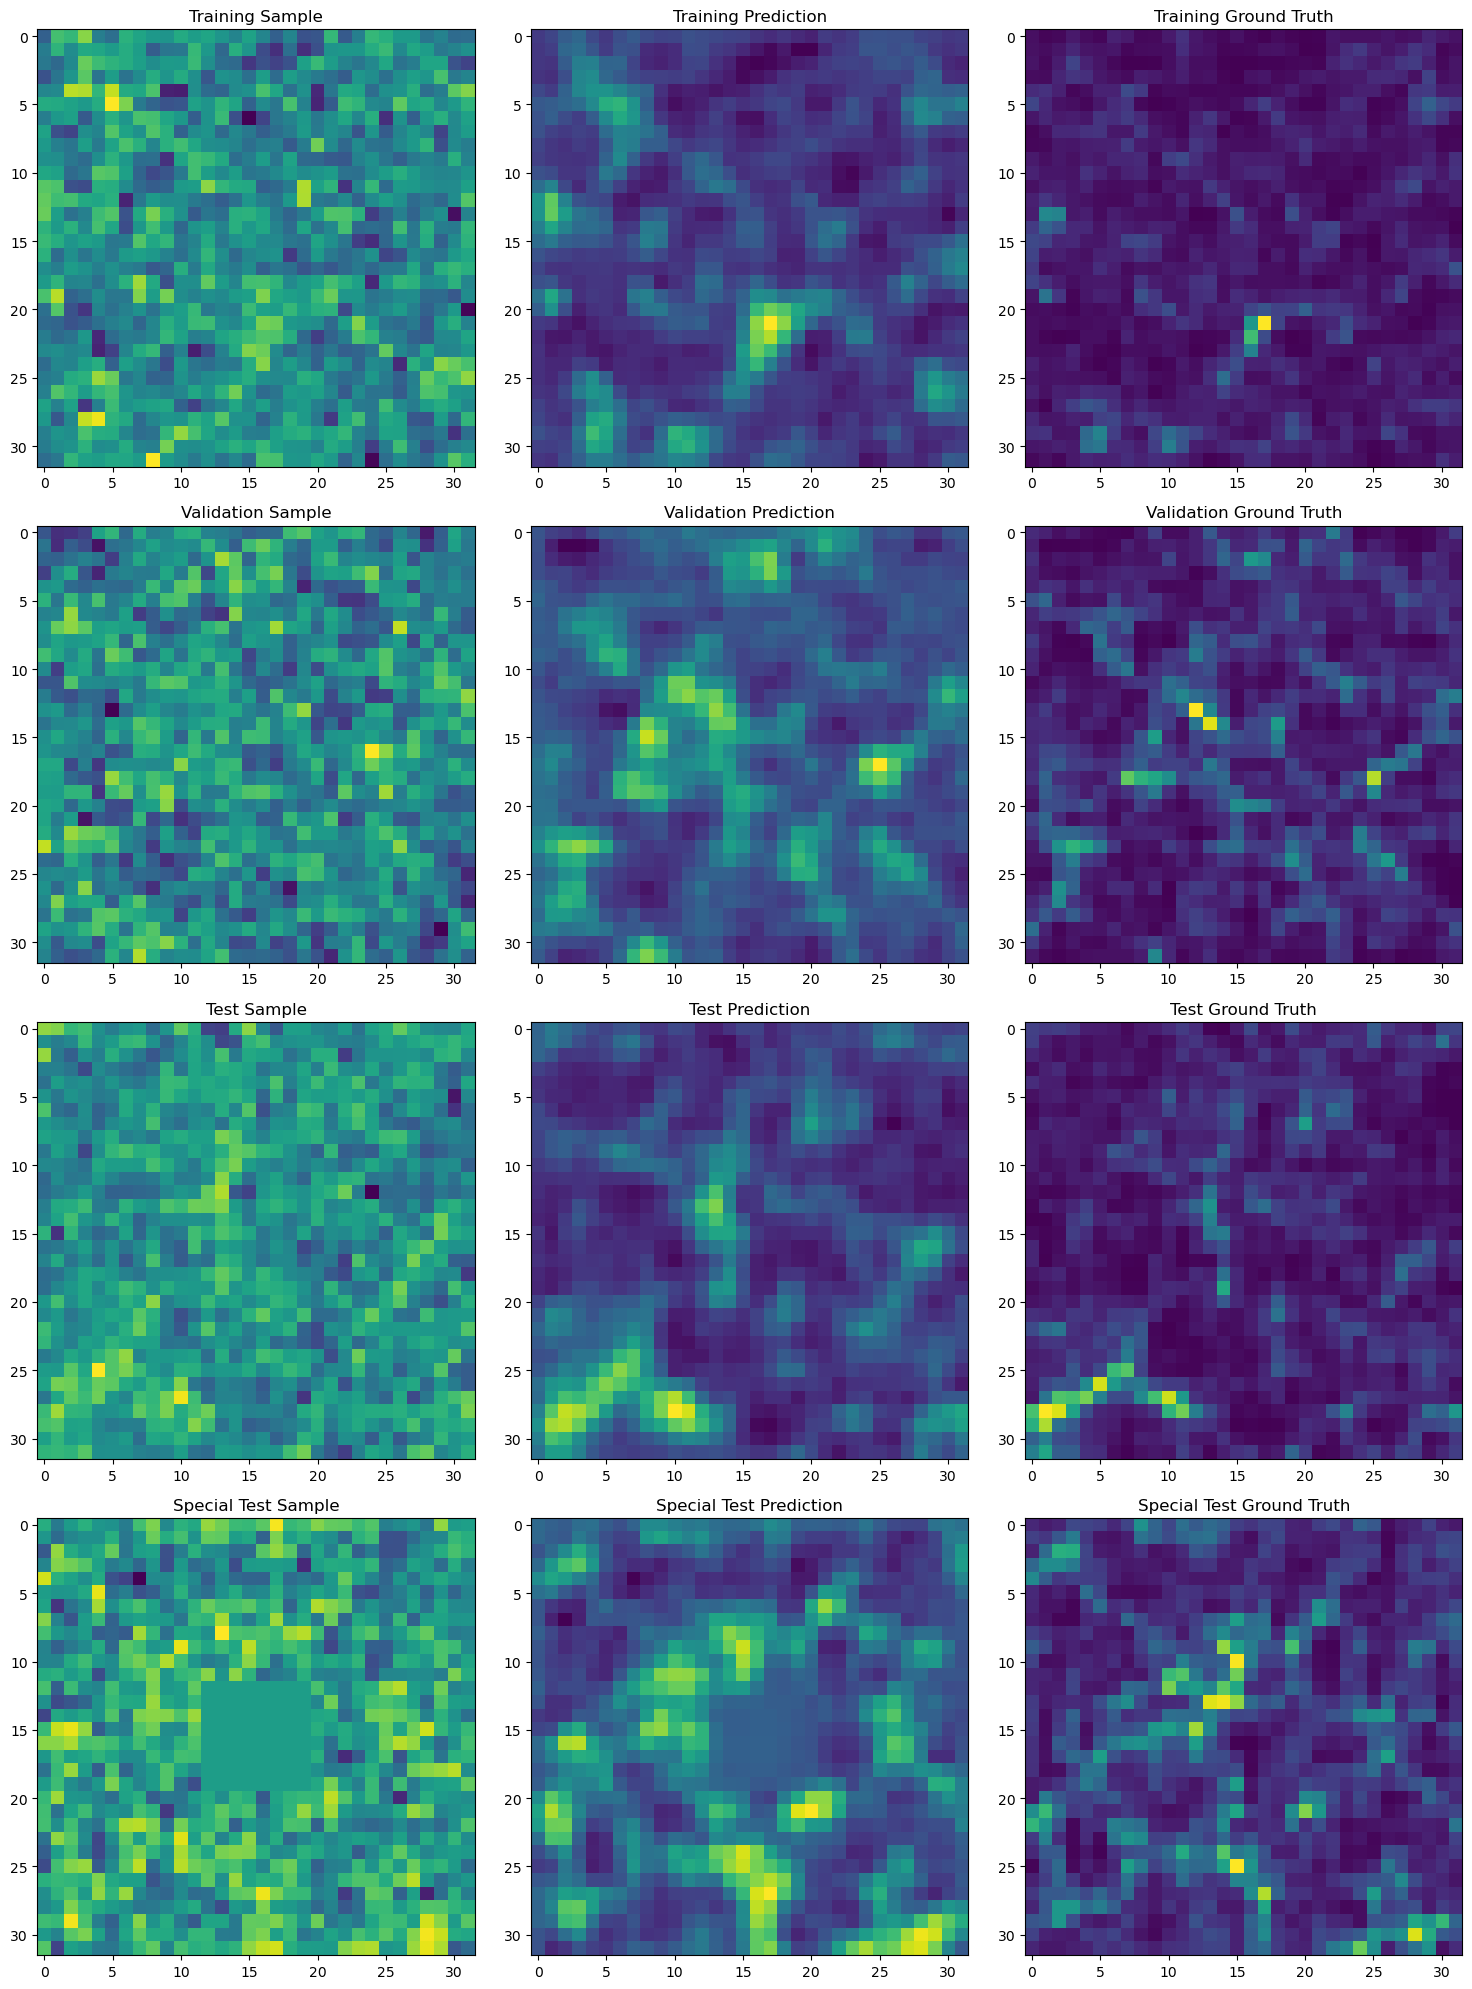

In [52]:
# Select one sample from each set
train_sample = X_train_combined[0]
val_sample = X_val[0]
test_sample = X_test[0]

# Predict on the samples
train_pred = vnet_model.predict(np.expand_dims(train_sample, axis=0))
val_pred = vnet_model.predict(np.expand_dims(val_sample, axis=0))
test_pred = vnet_model.predict(np.expand_dims(test_sample, axis=0))

# fn - sample plotting
def plot_sample(ax, sample, title):
    if sample.ndim == 4:  # For 4D arrays
        ax.imshow(sample[:, :, sample.shape[2] // 2, 0], cmap='viridis')
    elif sample.ndim == 3:  # For 3D arrays
        ax.imshow(sample[:, :, sample.shape[2] // 2], cmap='viridis')
    ax.set_title(title)

# 4x3 grid of plots
fig, axes = plt.subplots(4, 3, figsize=(15, 20))

# training sample
plot_sample(axes[0, 0], train_sample, "Training Sample")
plot_sample(axes[0, 1], train_pred[0], "Training Prediction")
plot_sample(axes[0, 2], y_train_combined[0], "Training Ground Truth")

# validation sample
plot_sample(axes[1, 0], val_sample, "Validation Sample")
plot_sample(axes[1, 1], val_pred[0], "Validation Prediction")
plot_sample(axes[1, 2], y_val[0], "Validation Ground Truth")

# test sample
plot_sample(axes[2, 0], test_sample, "Test Sample")
plot_sample(axes[2, 1], test_pred[0], "Test Prediction")
plot_sample(axes[2, 2], y_test[0], "Test Ground Truth")

# ground truth
plot_sample(axes[3, 0], X_val_modified[0], "Special Test Sample")
plot_sample(axes[3, 1], hidden_sample_prediction[0], "Special Test Prediction")
plot_sample(axes[3, 2], y_val_special_test, "Special Test Ground Truth")

plt.tight_layout()
plt.show()

# Script Complete